In [ ]:
!pip install awscli
import awscli
from google.colab import drive
!pip install pydicom
drive.mount("/content/drive", force_remount=True)

In [ ]:
!cat /content/drive/My\ Drive/config/awscli.ini
path = "/content/drive/My Drive/config/awscli.ini"
 
import os
!export AWS_SHARED_CREDENTIALS_FILE=/content/drive/My\ Drive/config/awscli.ini
path = "/content/drive/My Drive/config/awscli.ini"
os.environ['AWS_SHARED_CREDENTIALS_FILE'] = path

!aws s3 cp s3://medical-image-segmentation/lungs/70-10-20/train.zip .
!aws s3 cp s3://medical-image-segmentation/lungs/70-10-20/val.zip .
!aws s3 cp s3://medical-image-segmentation/lungs/70-10-20/test.zip .
!aws s3 cp s3://medical-image-segmentation/lungs/70-10-20/train-output.zip .
!aws s3 cp s3://medical-image-segmentation/lungs/70-10-20/val-output.zip .
!aws s3 cp s3://medical-image-segmentation/lungs/70-10-20/test-output.zip .

!unzip train.zip
!unzip val.zip
!unzip test.zip
!unzip train-output.zip
!unzip val-output.zip
!unzip test-output.zip

In [ ]:
# coding: utf-8
import os
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras
import matplotlib.pyplot as plt
!pip install keras_unet
from keras_unet.models import custom_unet

SEED = 909
BATCH_SIZE_TRAIN = 6
BATCH_SIZE_VAL = 6
BATCH_SIZE_TEST = 6
IMAGE_HEIGHT=512
IMAGE_WIDTH=512
IMG_SIZE = (IMAGE_HEIGHT,IMAGE_WIDTH)
NUM_TRAIN = 6651
NUM_VAL = 932
NUM_TEST = 1950

def create_train(img_path, mask_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    img_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = img_datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None,
       color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)

    mask_generator = mask_datagen.flow_from_directory(mask_path, target_size=IMG_SIZE, class_mode=None,
       color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, mask_generator)

train_img_path = os.path.join('train-output', 'images')
train_mask_path = os.path.join('train-output', 'masks')

val_img_path = os.path.join('val-output', 'images')
val_mask_path = os.path.join('val-output', 'masks')

test_img_path = os.path.join('test-output', 'images')
test_mask_path = os.path.join('test-output', 'masks')

train_generator = create_train(train_img_path, train_mask_path, BATCH_SIZE_TRAIN)
val_generator = create_train(val_img_path, val_mask_path, BATCH_SIZE_TRAIN)
test_generator = create_train(test_img_path, test_mask_path, BATCH_SIZE_TRAIN)

NUM_OF_EPOCHS = 100

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Found 6651 images belonging to 1 classes.
Found 6651 images belonging to 1 classes.
Found 932 images belonging to 1 classes.
Found 932 images belonging to 1 classes.
Found 1950 images belonging to 1 classes.
Found 1950 images belonging to 1 classes.


In [ ]:
def display(display_list):
    plt.figure(figsize=(15,15))
    title = ['Input', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])

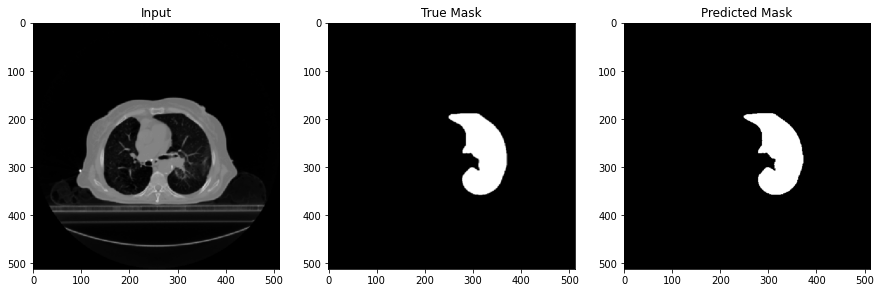

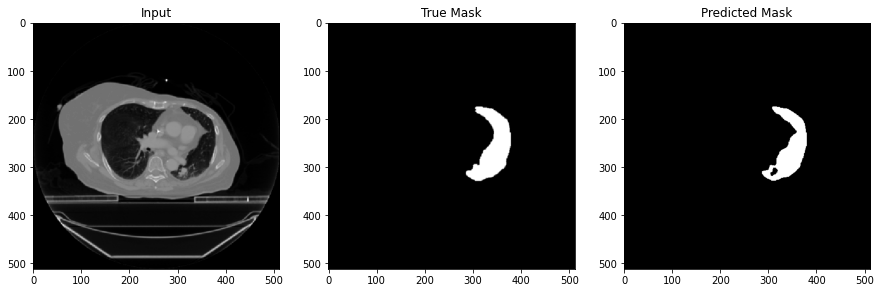

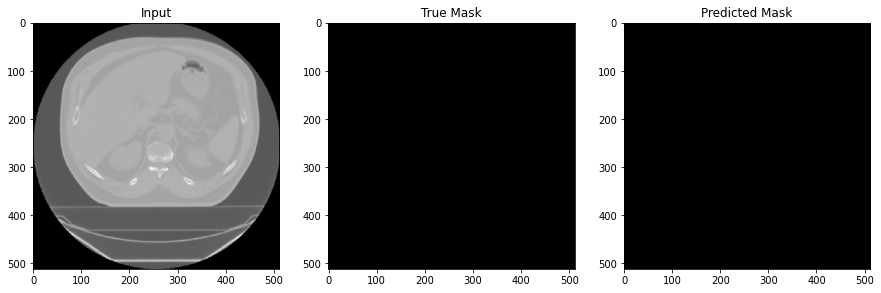

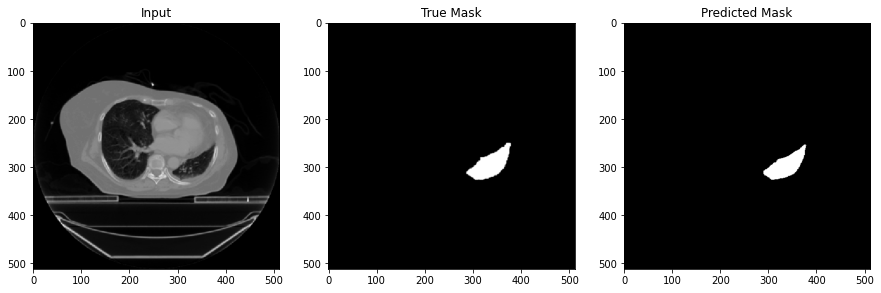

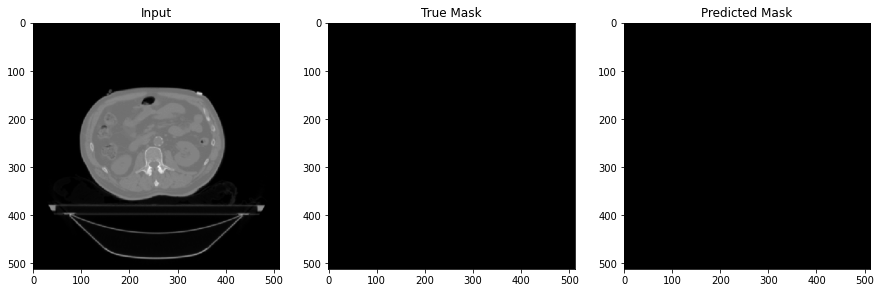

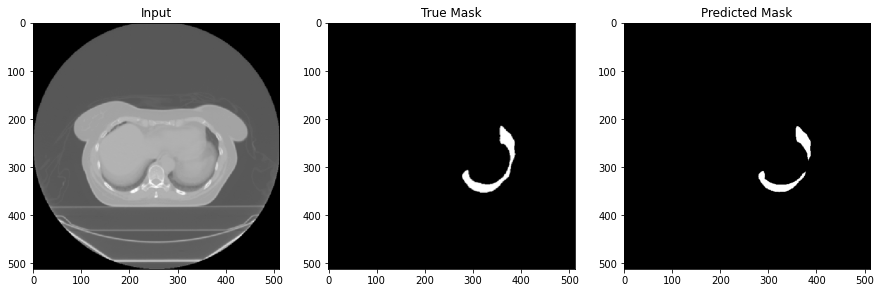

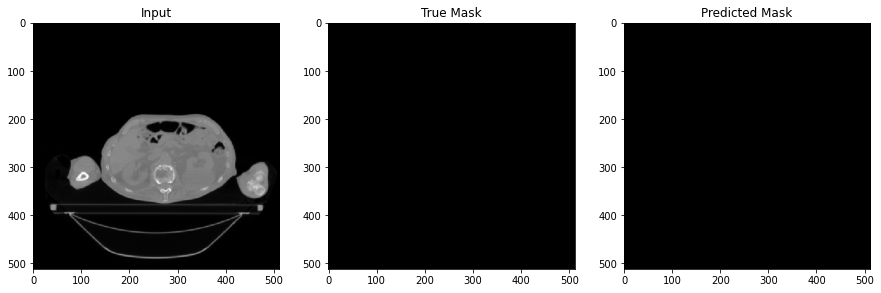

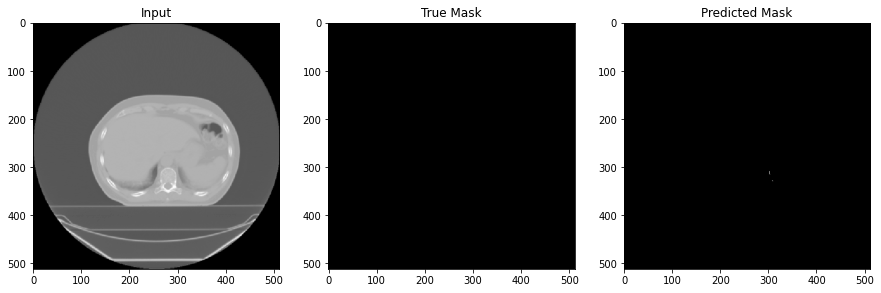

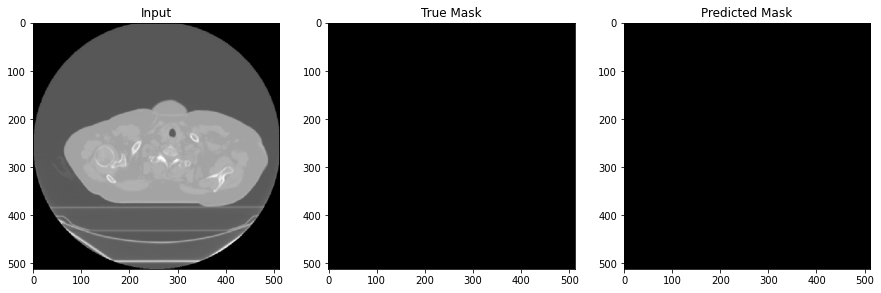

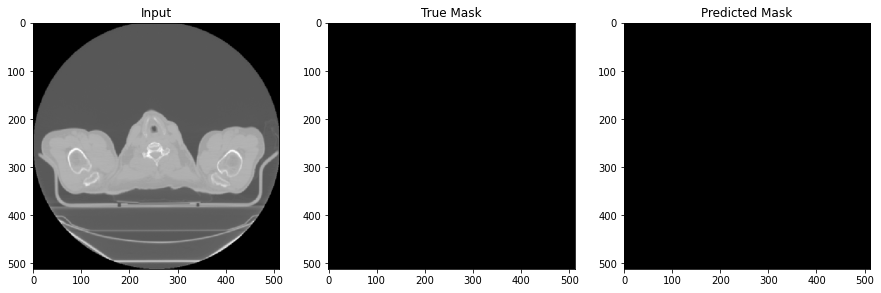

In [ ]:
show_prediction(train_generator, 10)

In [ ]:
import keras.backend as K
import math
def DiceLoss(targets, inputs, smooth=1e-6):
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(targets * inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

In [ ]:
model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=True,
    num_classes=1,
    filters=64,
    dropout=0.25,
    output_activation='sigmoid')

In [ ]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_VAL = NUM_VAL // BATCH_SIZE_VAL
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST
model.compile(optimizer='adam', loss=DiceLoss, metrics=[DiceLoss, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()], run_eagerly=True)

In [ ]:
model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    validation_data=val_generator, 
                    validation_steps=EPOCH_STEP_VAL,
                    epochs=20)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
1108/1108 [==============================] - 1081s 957ms/step - loss: 0.3954 - DiceLoss: 0.3954 - precision: 0.2768 - recall: 0.7399 - val_loss: 0.1726 - val_DiceLoss: 0.1726 - val_precision: 0.9048 - val_recall: 0.8215
Epoch 2/20
1108/1108 [==============================] - 1024s 921ms/step - loss: 0.1433 - DiceLoss: 0.1433 - precision: 0.9106 - recall: 0.8614 - val_loss: 0.1873 - val_DiceLoss: 0.1873 - val_precision: 0.9866 - val_recall: 0.7137
Epoch 3/20
1108/1108 [==============================] - 1060s 957ms/step - loss: 0.1011 - DiceLoss: 0.1010 - precision: 0.9455 - recall: 0.9038 - val_loss: 0.0610 - val_DiceLoss: 0.0610 - val_precision: 0.9654 - val_recall: 0.9559
Epoch 4/20
1108/1108 [==============================] - 1061s 957ms/step - loss: 0.0868 - DiceLoss: 0.0868 - precision: 0.9555 - recall: 0.9185 - val_loss: 0.0565 - val_DiceLoss: 0.0565 - val_precision: 0.9545 - val_recall: 0.9715
Epoch 5/20
1108/1108 [==============================] - 1060s 957ms/step - l

In [ ]:
model.save(f'drive/MyDrive/UNET5-A99-P93-R88-{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5')

In [ ]:
model = keras.models.load_model(f'drive/MyDrive/UNET4-A99-P93-R88-{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5', custom_objects={"DiceLoss": DiceLoss})

In [ ]:
def dice_gen(img_path, mask_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    img_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = img_datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None,
       color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED, shuffle=False)

    mask_generator = mask_datagen.flow_from_directory(mask_path, target_size=IMG_SIZE, class_mode=None,
       color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED, shuffle=False)
    return img_generator, mask_generator

In [ ]:
from pydicom import dcmread
import statistics
from os import listdir
from os.path import join

# make sure metrics.py and lookup_tables.py is uploaded into runtime
from metrics import compute_surface_distances, compute_surface_dice_at_tolerance

def get_distances(path):
  distances = {}
  for subdir in listdir(path):
    for image in listdir(join(path, subdir, "images")):
      dimensions = dcmread(join(path, subdir, "images", image)).PixelSpacing
      png_name = "lung_l/" + subdir + "-" + image + ".png"
      distances[png_name] = [d for d in dimensions]                             # change this ratio if image dimensions change
  return distances

def get_surface_dice_values(img_path, mask_path, batch_size, iterations, pixel_distances):
  index = 0
  dice_list = []
  image_gen, mask_gen = dice_gen(img_path, mask_path, batch_size)
  files = image_gen.filenames

  for i in range(iterations):
    image, mask = next(image_gen), next(mask_gen)
    pred_masks = model.predict(image)
    

    for j in range(batch_size):
      pred_mask = pred_masks[j] > 0.5                                           # not sure if this is correct thing to do
      bool_mask = mask[j].astype(bool)
      mask_gt = bool_mask.reshape((512, 512))
      predicted_mask = pred_mask.reshape((512, 512))

      surface_distances = compute_surface_distances(mask_gt, predicted_mask, pixel_distances[files[index]])
      surface_dice = compute_surface_dice_at_tolerance(surface_distances, 1.9)
      
      dice_list.append(surface_dice)
      index += 1
  return dice_list
  
def compute_surface_dice_stats(dice_list):
  filtered_dice_list = []
  for val in dice_list:
    if not math.isnan(val):
      filtered_dice_list.append(val)
  filtered_dice_list.sort()
  mean = sum(filtered_dice_list) / len(filtered_dice_list)
  median = filtered_dice_list[len(filtered_dice_list) // 2]
  std_dev = statistics.stdev(filtered_dice_list)
  return mean, median, std_dev


In [ ]:
# split can be either train, val or test

def surface_dice(split):
  if split == "train":
    img_path, mask_path = train_img_path, train_mask_path
    batch_size, iterations = BATCH_SIZE_TRAIN, EPOCH_STEP_TRAIN
  elif split == "val":
    img_path, mask_path = val_img_path, val_mask_path
    batch_size, iterations = BATCH_SIZE_VAL, EPOCH_STEP_VAL
  elif split == "test":
    img_path, mask_path = test_img_path, test_mask_path
    batch_size, iterations = BATCH_SIZE_TEST, EPOCH_STEP_TEST
  else:
    assert False, "invalid split"
  
  pixel_distances = get_distances(split)
  dice_list = get_surface_dice_values(img_path, mask_path, batch_size, iterations, pixel_distances)
  return compute_surface_dice_stats(dice_list)
  

In [ ]:
d_list = surface_dice("val")

Found 932 images belonging to 1 classes.
Found 932 images belonging to 1 classes.


/content/metrics.py:422: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(surfel_areas_gt) + np.sum(surfel_areas_pred))


(0.6920771747785295, 0.7835427508309158, 0.2480363875033315)


# Code below is for testing purposes

1. reformat images to be 512 x 512 to allow for better tolerances 
2. check surface_dice calcuations and make sure they are correct
3. 3 is trained on 70 split 256x256 50 epochs, 4 is trained on 70 split 512x512 50 epochs

In [ ]:
from pydicom import dcmread

def get_distances(path):
  distances = {}
  for subdir in listdir(path):
    for image in listdir(join(path, subdir, "images")):
      dimensions = dcmread(join(path, subdir, "images", image)).PixelSpacing
      png_name = "lung_l/" + subdir + "-" + image + ".png"
      distances[png_name] = [d for d in dimensions]                         # change this ratio if image dimensions change
  return distances

distances = get_distances("val")

In [ ]:
image_gen, mask_gen = dice_gen(train_img_path, train_mask_path, BATCH_SIZE_TRAIN)
files = image_gen.filenames

Found 6651 images belonging to 1 classes.
Found 6651 images belonging to 1 classes.


/content/metrics.py:422: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(surfel_areas_gt) + np.sum(surfel_areas_pred))


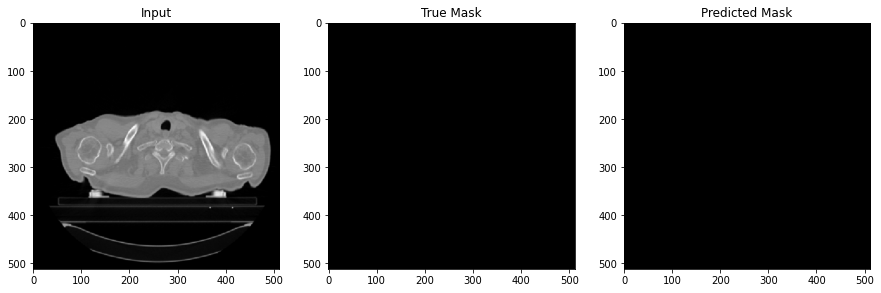

surface dice: nan


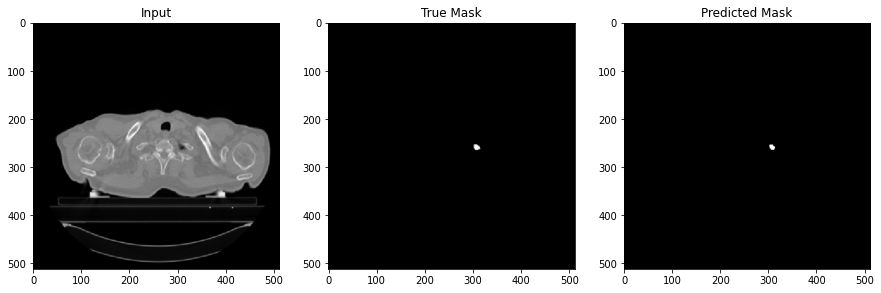

surface dice: 0.7072002095816033


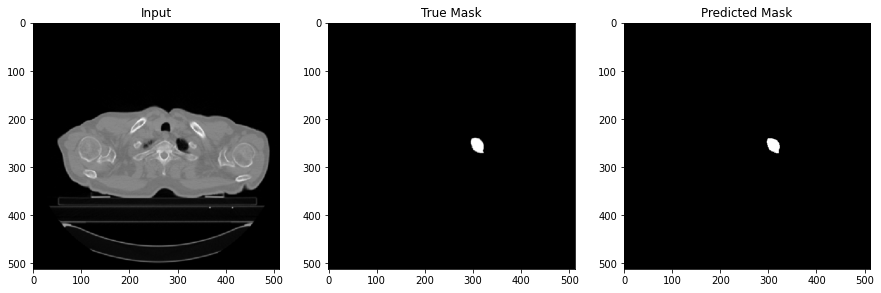

surface dice: 0.780056156116519


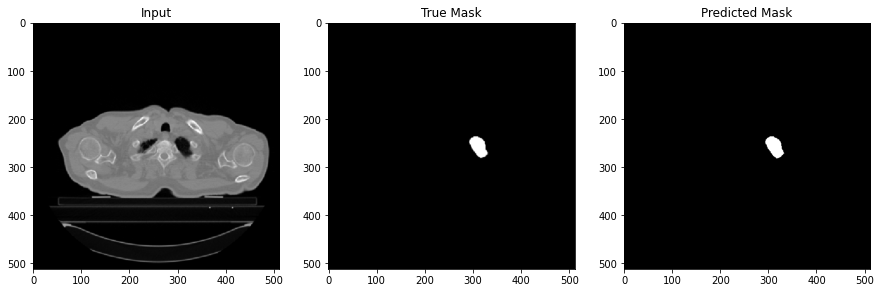

surface dice: 0.8602128076763054


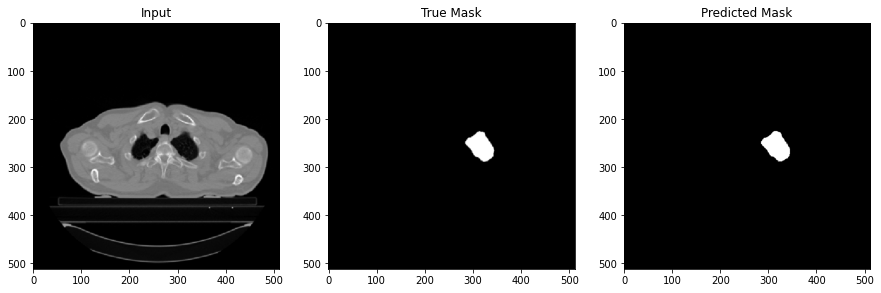

surface dice: 0.8691023675896801


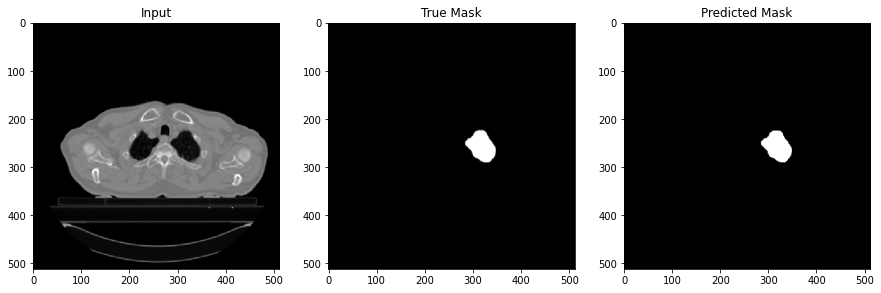

surface dice: 0.7447020806137503


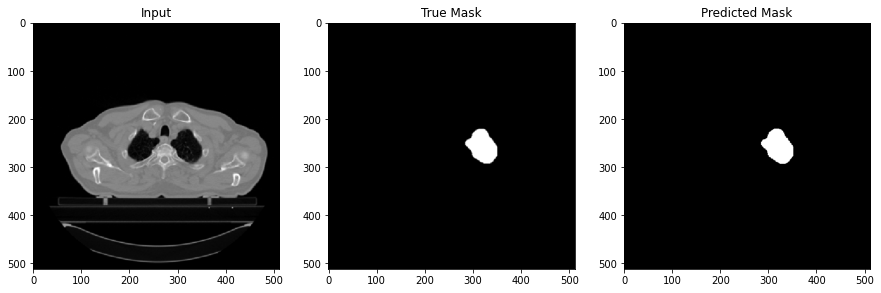

surface dice: 0.9009124432550283


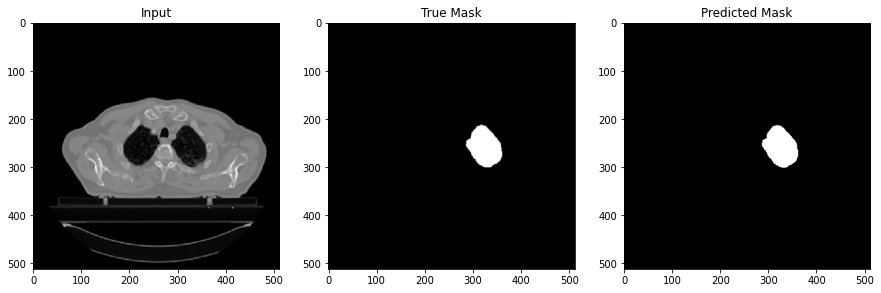

surface dice: 0.848503092520069


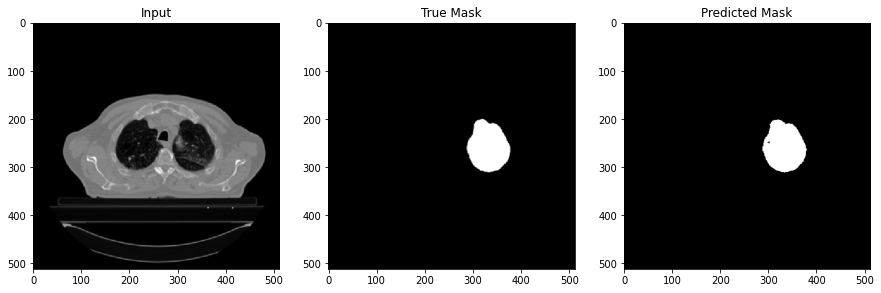

surface dice: 0.8438246824810033


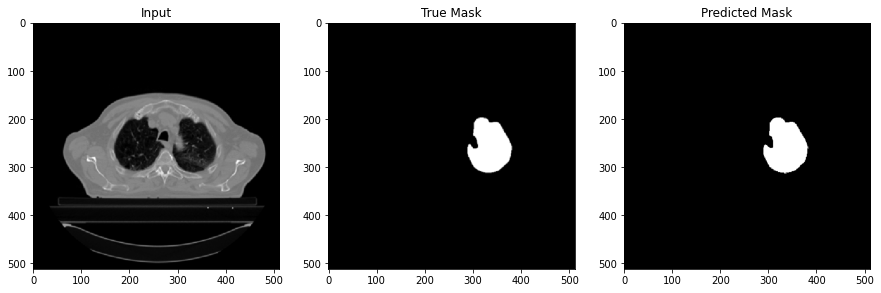

surface dice: 0.8740151515212385


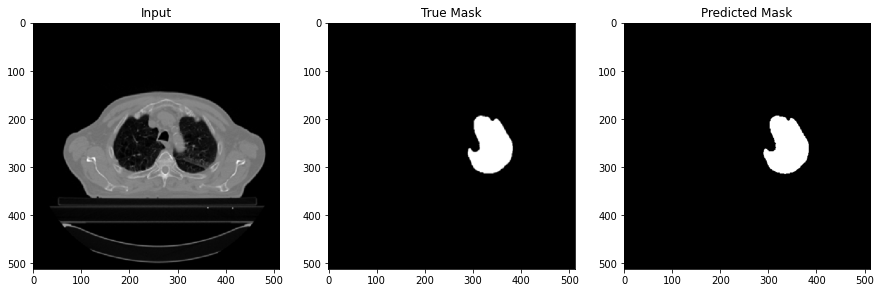

surface dice: 0.8737005949023425


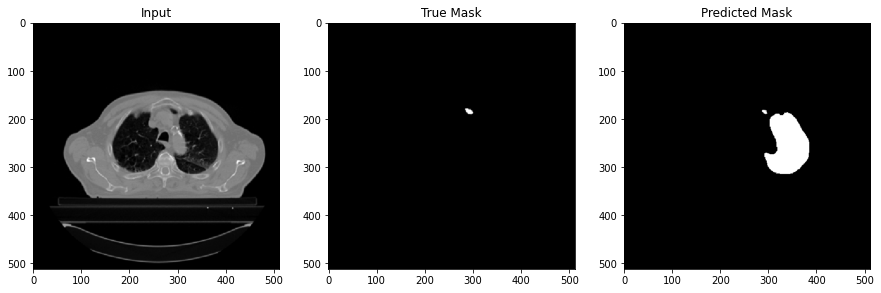

surface dice: 0.05138916972396566


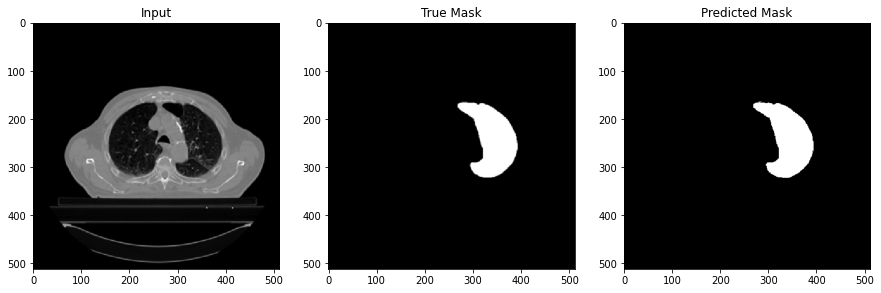

surface dice: 0.8666060072903056


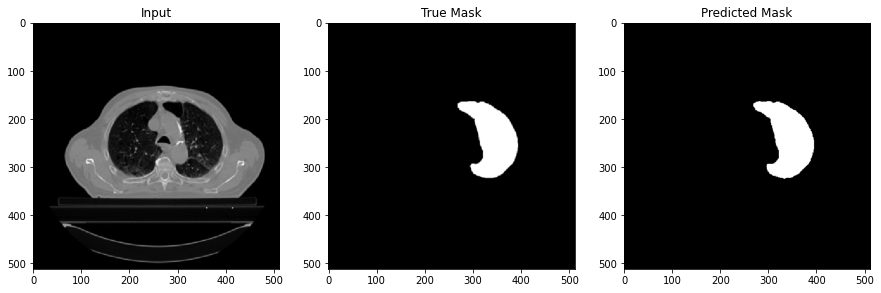

surface dice: 0.8629503664234557


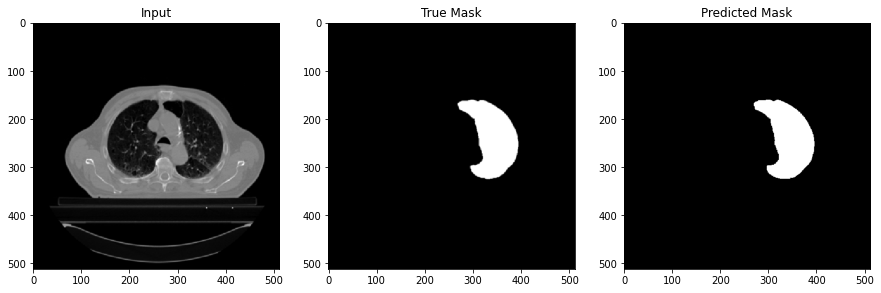

surface dice: 0.8880175979274381


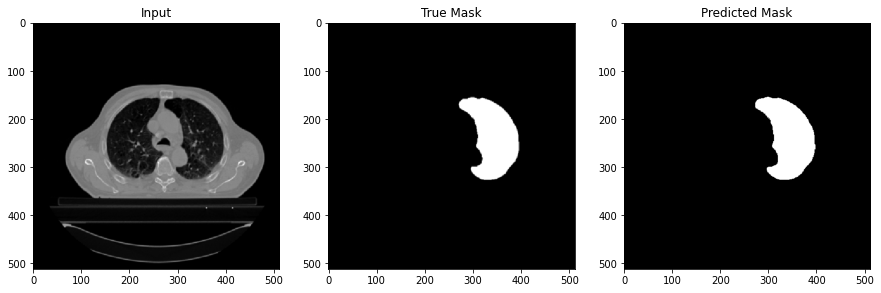

surface dice: 0.8488328284133227


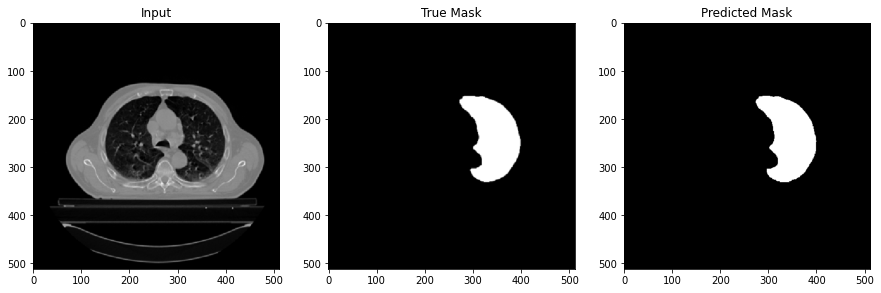

surface dice: 0.848199375270917


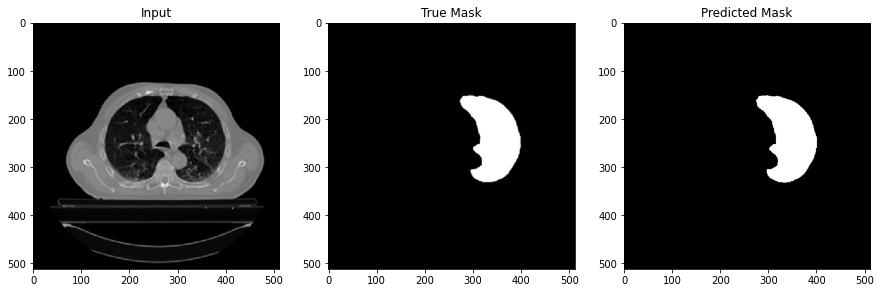

surface dice: 0.8763656764945331


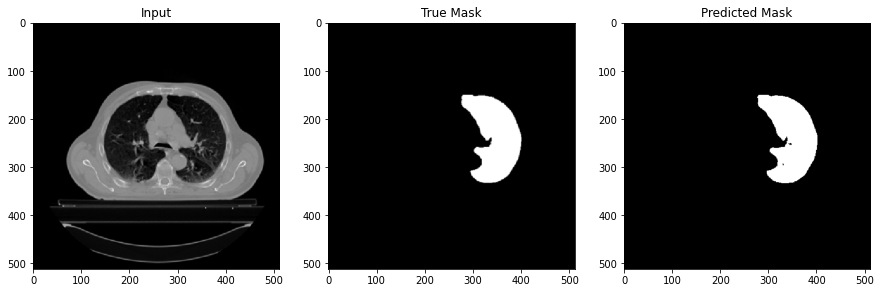

surface dice: 0.8349919009928272


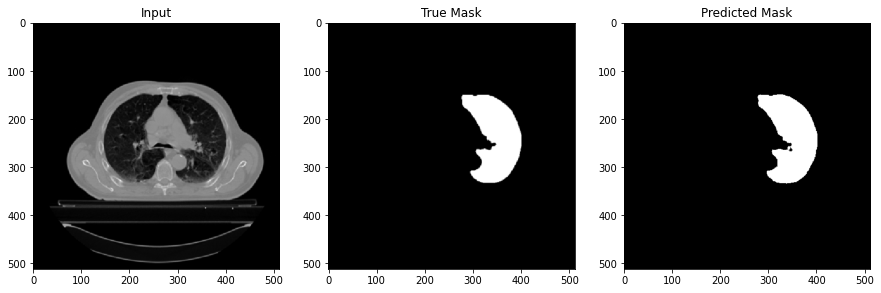

surface dice: 0.8483159649261316


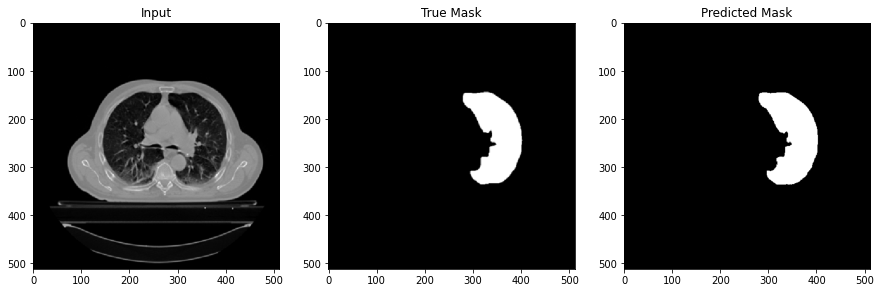

surface dice: 0.9099129539851614


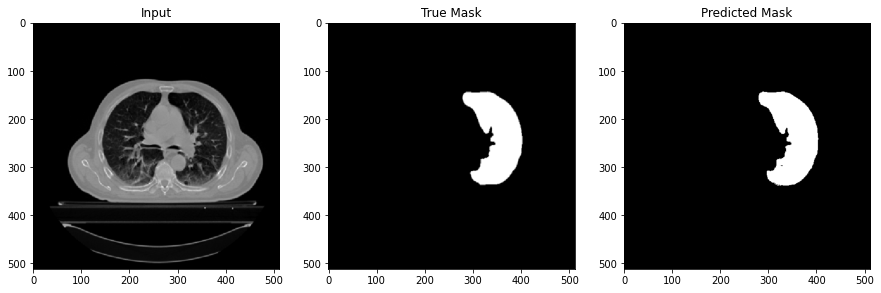

surface dice: 0.8492735514523201


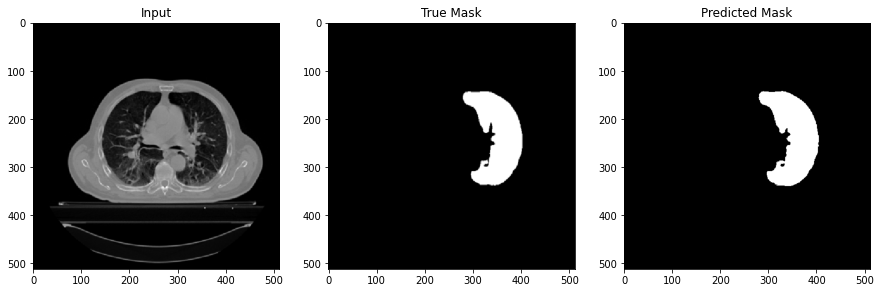

surface dice: 0.8478470642967268


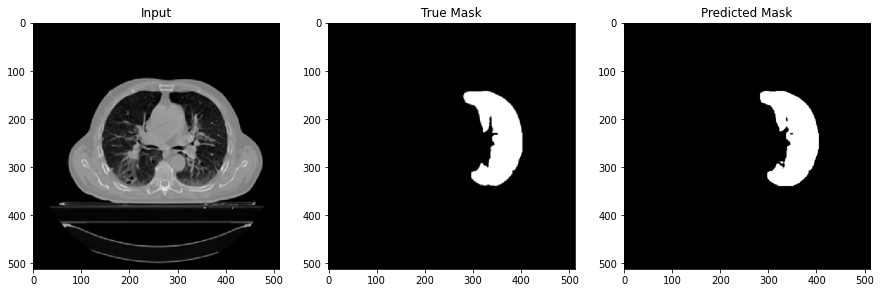

surface dice: 0.8104753407692031


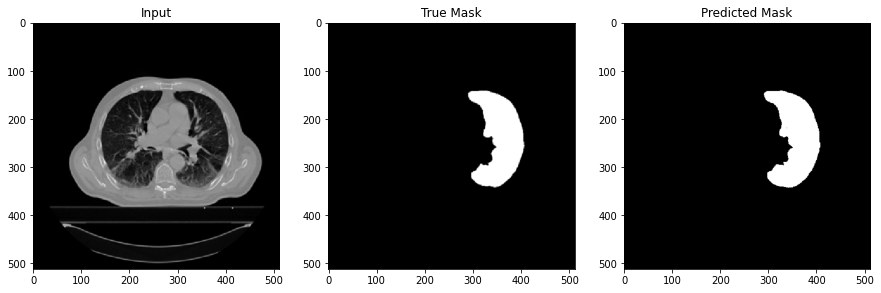

surface dice: 0.852145144590175


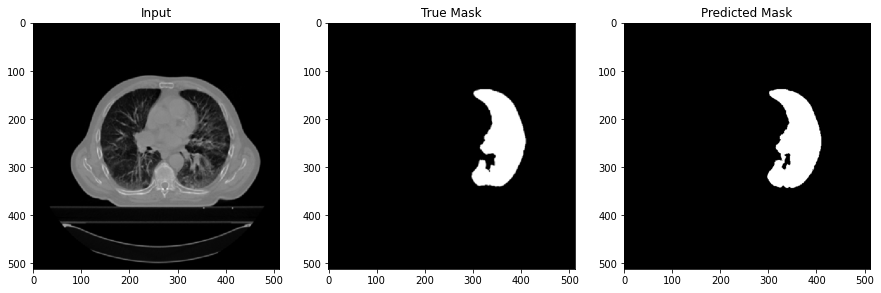

surface dice: 0.8007355243684254


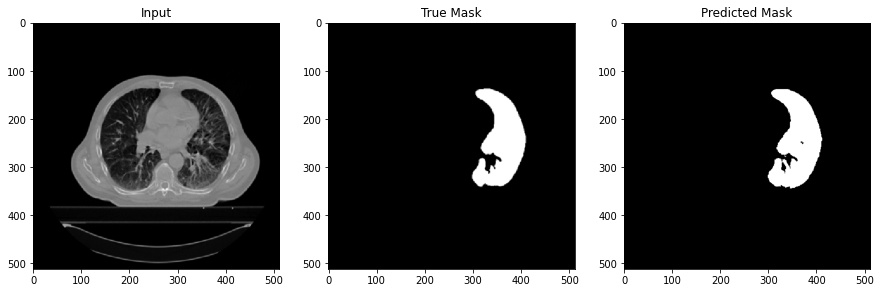

surface dice: 0.8010405442399755


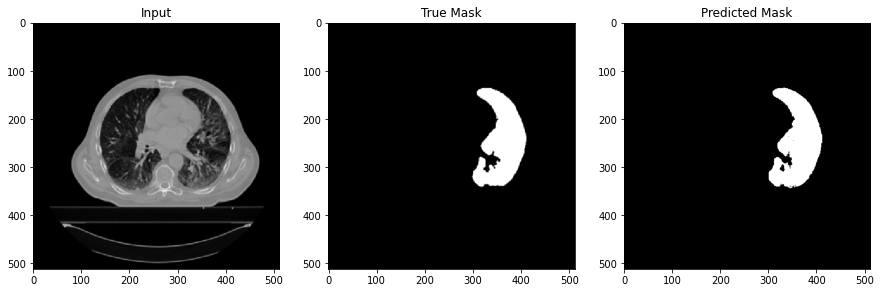

surface dice: 0.8034550059843981


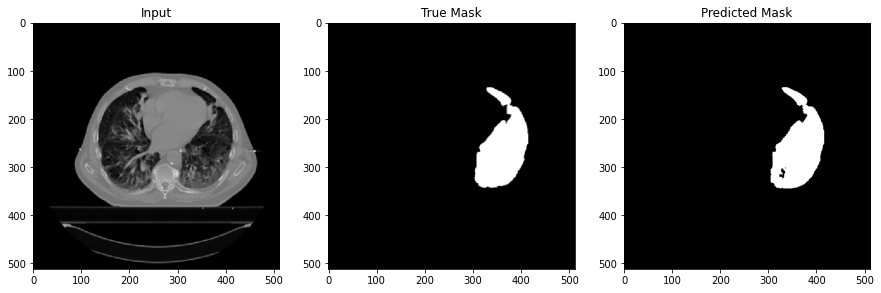

surface dice: 0.8256833584265226


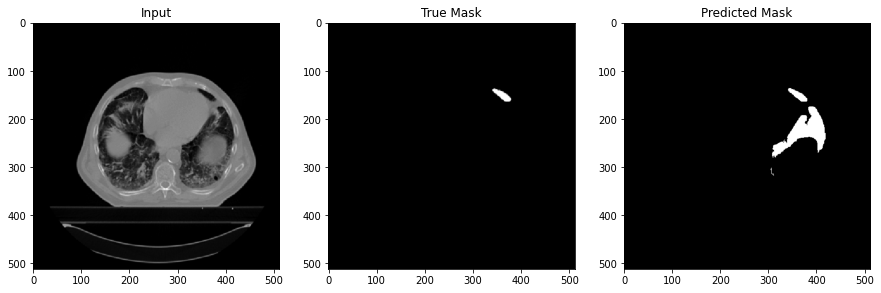

surface dice: 0.2222834524887212


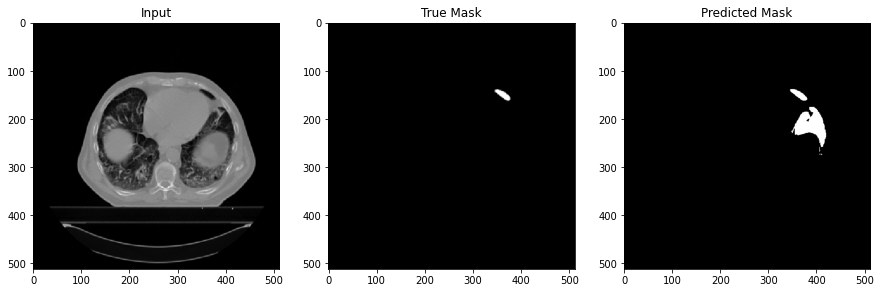

surface dice: 0.33140351602669704


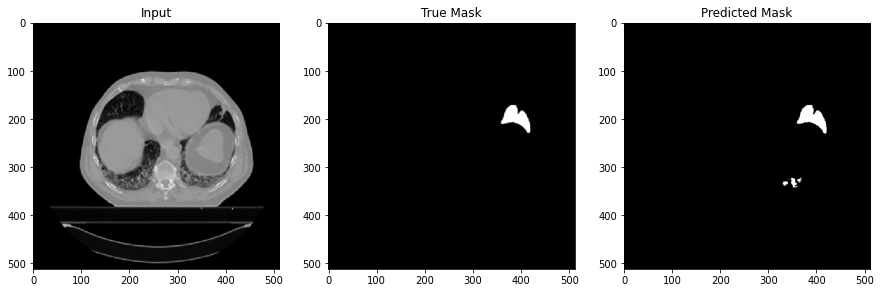

surface dice: 0.6154945900094252


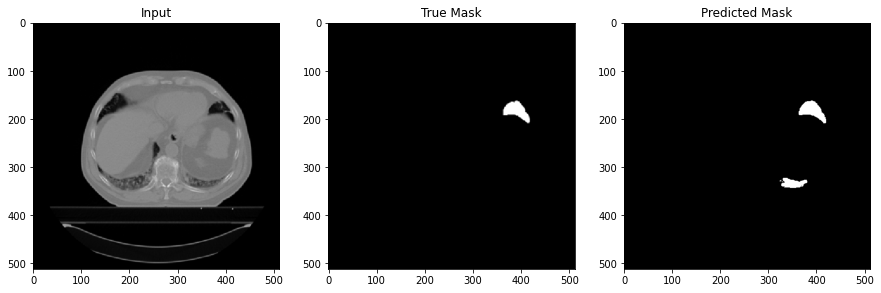

surface dice: 0.5498229595641557


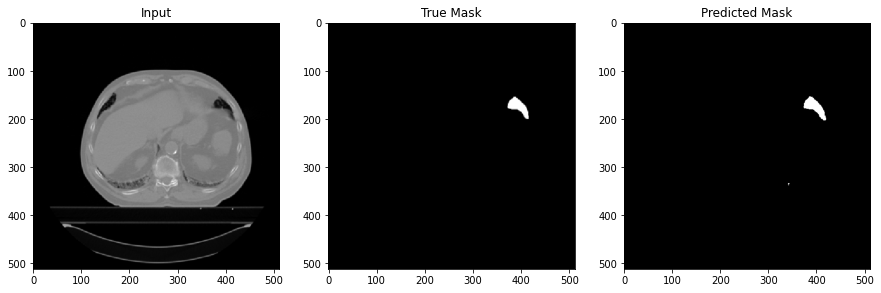

surface dice: 0.8564938708971057


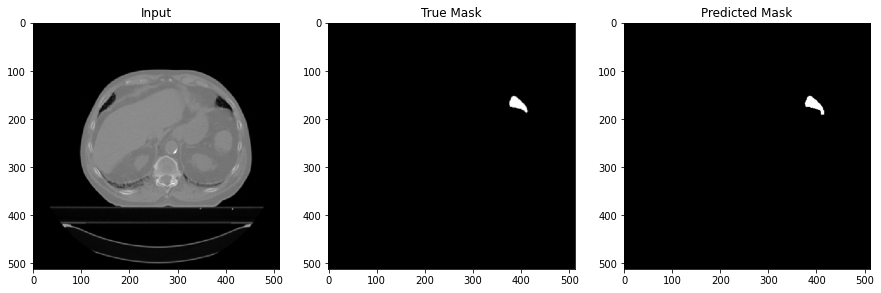

surface dice: 0.8513357232544758


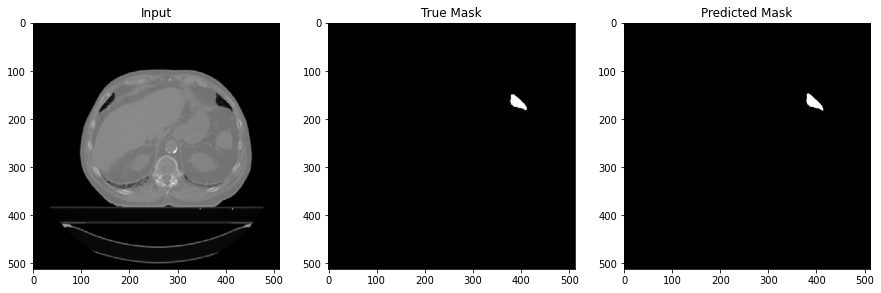

surface dice: 0.8311008905024365


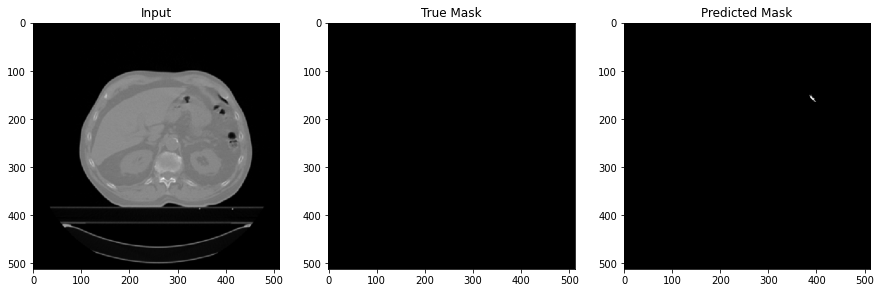

surface dice: 0.0


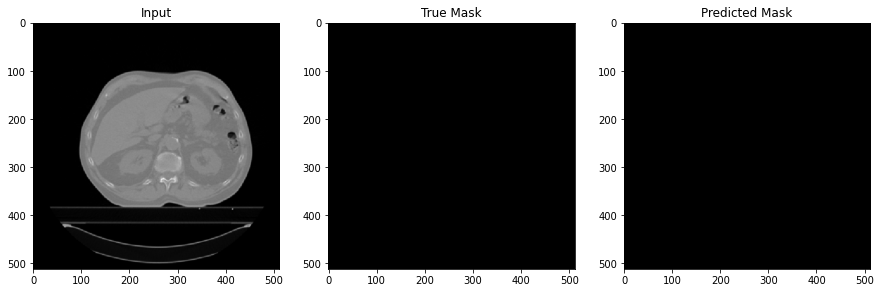

surface dice: nan


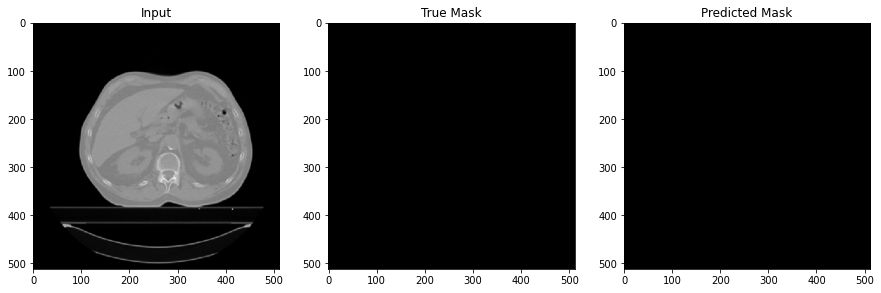

surface dice: nan


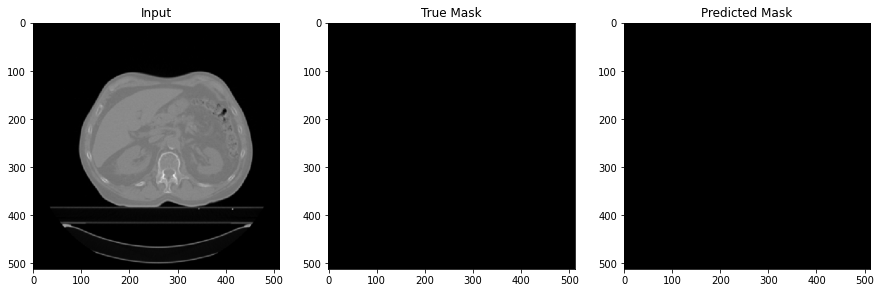

surface dice: nan


KeyboardInterrupt: ignored

In [ ]:
index = 0
dice_list = []
for i in range(1662):
  image,mask = next(image_gen), next(mask_gen)
  pred_masks = model.predict(image)
  for j in range(4):
    pred_mask = pred_masks[j] > 0.5
    bool_mask = mask[j].astype(bool)
    
    mask_gt = bool_mask.reshape((512, 512))
    predicted_mask = pred_mask.reshape((512, 512))

    surface_distances = compute_surface_distances(mask_gt, predicted_mask, [1.9, 1.9])
    surface_dice = compute_surface_dice_at_tolerance(surface_distances, 1.9)
    display([image[j], mask[j], pred_mask])
    print("surface dice: " + str(surface_dice))
    dice_list.append(surface_dice)
    index += 1

In [ ]:
count = 0
total = 0
for val in dice_list:
  if not math.isnan(val):
    count += 1
    total += val

print(total/count)

0.8876650726948787


In [ ]:
print(dice_list)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 1.0, 1.0, 0.8599316841507596, 0.933058261758408, 0.9900083191854215, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9865510666395846, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9952340867985054, 1.0, 1.0, 1.0, 0.9900283465436729, 0.8730473937305941, 0.975263693278846, 0.9800271163342484, 0.9965604424051601, 1.0, 0.9746552121178854, 0.10355339059327374, 0.9782623416471518, 0.9807922969454151, 0.9946255634684573, 1.0, 1.0, 1.0, 0.9973554210986032, 1.0, 0.9948580891939856, 1.0, 0.9974636938553405, 1.0, 0.9923656441447171, 0.9948250234350134, 1.0, 1.0, 0.9975764468385668, 0.9975102500080574, 0.995210588948879, 1.0, 0.993371021890863, 1.0, 0.980145940192369, 0.9977269163916047, 0.97510778799494, 0.99560344466308, 0.9760730242919254, 0.9902608607588155, 0.982057300164694

In [ ]:
!cp test.zip drive/MyDrive/medical-image-segmentation/70-10-20/
!cp train.zip drive/MyDrive/medical-image-segmentation/70-10-20/
!cp val.zip drive/MyDrive/medical-image-segmentation/70-10-20/